# Fitting and Simulating HITRAN Static LBL Molecules
HITRAN has a select number of molecules that have line by line data available, but are provided in static .par files opposed to the HITRANOnline format.  This example serves to show users how to treat these molecules in MATS.

In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import MATS
from MATS.hapi import PYTIPS2011, PYTIPS2017


import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")

HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Convert .par file into MATS format
.par formatting is provided in Table 1 of the HITRAN 2004 paper 

L.S. Rothman, D. Jacquemart, A. Barbe, D. Chris Benner, M. Birk, L.R. Brown, M.R. Carleer, C. Chackerian, K. Chance, L.H. Coudert, V. Dana, V.M. Devi, J.-M. Flaud, R.R. Gamache, A. Goldman, J.-M. Hartmann, K.W. Jucks, A.G. Maki, J.-Y. Mandin, S.T. Massie, J. Orphal, A. Perrin, C.P. Rinsland, M.A.H. Smith, J. Tennyson, R.N. Tolchenov, R.A. Toth, J. Vander Auwera, P. Varanasi, G. Wagner,
The HITRAN 2004 molecular spectroscopic database, Journal of Quantitative Spectroscopy and Radiative Transfer, Volume 96, Issue 2, 2005,
Pages 139-204, https://doi.org/10.1016/j.jqsrt.2004.10.008

Users will need to download the .par file provided by HITRAN for desired molecule.  

This example uses CF4 and a portion of the HITRAN provided .par file.  The entire HITRAN .par file can be used (and has been tested locally), but is above the github file storage recommendation.  

In [2]:
molecule = 'CF4'

filename = '42_hit20_500_800.par'

PARAM_LINELIST = pd.DataFrame()
with open(filename) as file:
    PARAM_LINELIST['molec_id'] = [int(line[0:2]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['local_iso_id'] = [int(line[2:3]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['nu'] = [float(line[3:15]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['sw'] = [float(line[15:25]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['elower'] = [ float(line[45:55]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['gamma0_air'] = [ float(line[35:40]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['n_gamma0_air'] = [ float(line[55:59]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['delta0_air'] = [ float(line[59:67]) for line in file]
with open(filename) as file:
    PARAM_LINELIST['gamma0_self'] = [ float(line[40:45]) for line in file]

    

PARAM_LINELIST['delta0_self'] = PARAM_LINELIST['delta0_air'].values
PARAM_LINELIST['n_gamma0_self'] = PARAM_LINELIST['n_gamma0_air'].values
PARAM_LINELIST['n_delta0_air'] = 0
PARAM_LINELIST['n_delta0_self'] = 0
PARAM_LINELIST['SD_gamma_air'] = 0
PARAM_LINELIST['SD_gamma_self'] = 0
PARAM_LINELIST['n_gamma2_air'] = PARAM_LINELIST['n_gamma0_air'].values
PARAM_LINELIST['n_gamma2_self'] = PARAM_LINELIST['n_gamma0_self'].values
PARAM_LINELIST['SD_delta_air'] = 0
PARAM_LINELIST['SD_delta_self'] = 0
PARAM_LINELIST['n_delta2_air'] = 0
PARAM_LINELIST['n_delta2_self'] = 0
PARAM_LINELIST['nuVC_air'] = 0
PARAM_LINELIST['nuVC_self'] = 0
PARAM_LINELIST['n_nuVC_air'] = 1
PARAM_LINELIST['n_nuVC_self'] = 1
PARAM_LINELIST['eta_air'] = 0
PARAM_LINELIST['eta_self'] = 0
PARAM_LINELIST['y_air'] = 0
PARAM_LINELIST['y_self'] = 0
PARAM_LINELIST['n_y_air'] = 1 #used in MATS versions 3 (current development version) and higher 
PARAM_LINELIST['n_y_self'] = 1#used in MATS versions 3 (current development version) and higher 

PARAM_LINELIST = PARAM_LINELIST[['molec_id', 'local_iso_id', 'nu', 'elower', 'sw', 
                                'gamma0_air', 'n_gamma0_air', 'delta0_air', 'n_delta0_air', 
                                'SD_gamma_air', 'n_gamma2_air', 'SD_delta_air', 'n_delta2_air', 
                                'nuVC_air', 'n_nuVC_air', 'eta_air', 'y_air', 'n_y_air', 
                                'gamma0_self', 'n_gamma0_self', 'delta0_self', 'n_delta0_self', 
                                'SD_gamma_self', 'n_gamma2_self', 'SD_delta_self', 'n_delta2_self', 
                                'nuVC_self', 'n_nuVC_self', 'eta_self', 'y_self', 'n_y_self',]]
PARAM_LINELIST.sort_values(by = ['nu'], inplace = True)
#PARAM_LINELIST.to_csv(molecule + '_ParameterLinelist.csv', index = False) #Can save to .csv file, but it is a large file, so you might want to truncate before saving

Text(0, 0.5, 'Line Intensity \n (cm$^{-1}$ / (molecule $\\cdot$ cm$^{-2}$))')

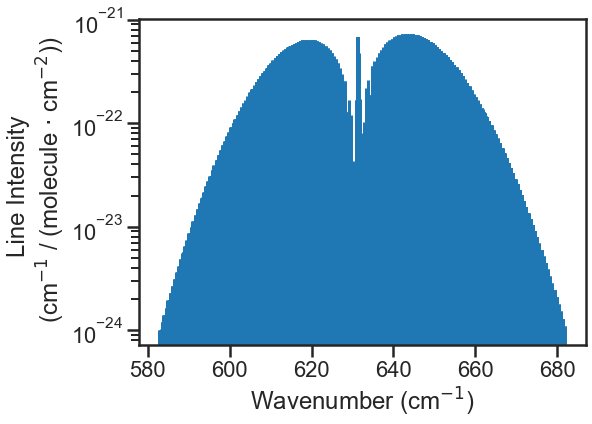

In [3]:
plt.figure(figsize=(8, 6))
plt.stem(PARAM_LINELIST['nu'], PARAM_LINELIST['sw'], use_line_collection = True, markerfmt = " ")
plt.yscale('log')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Line Intensity \n (cm$^{-1}$ / (molecule $\cdot$ cm$^{-2}$))')



While these molecules are available in HITRAN, the molecules available in the TIPS-2011 and TIPS-2017 partition function libraries differ.  For example in hapi TIPS-2011 has information for CF4, where TIPS-2017 is an array of zeros.  This leads to nan values for the at simulation temperature line intensities.  We added the MATS capability to switch from the default TIPS-2017 to TIPS-2011, so that this molecule could be appropriately simulated.  Below is a summary of molecules, where this might be an issue.  For molecules with no TIPS available the TIPS call with through an error and the 296 line intensity will be used.

TIPS 2011 Only
* SO3, M = 46, I =1
* CF4, M = 42, I = 1

No TIPS data
* HNO3, M = 12, I = 2
* HF, M = 14, I = 2
* HCl, M = 15, I = 3, 4
* HBr, M = 16, I = 3, 4
* HI, M = 17, I = 2
* N2, M = 22, I = 2
* COF2, M = 29, I = 2
* O, M = 34, I = 1
* CH3OH, M = 38, I=1


c:\users\ema3\mats\MATS\spectrum.py:144: RuntimeWarning: divide by zero encountered in reciprocal
  self.tau = (self.alpha*CONSTANTS['c'] / 1e12)**-1
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


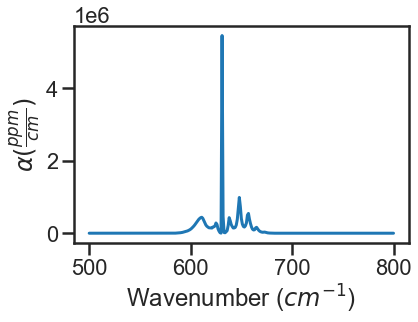

In [4]:
#PARAM_LINELIST = pd.read_csv('CF4_ParameterLinelist.csv') # Option to read in so you don't have to generate the file every time


wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
baseline_terms = [0] #polynomial baseline coefficients where the index is equal to the coefficient order

sample_molefraction = {42 :1} #The number here is the molec_id number can be found https://hitran.org/docs/iso-meta/
wave_min = 500 #cm-1
wave_max = 800 #cm-1
wave_space = 1 #cm-1
SNR = None #if None, then infinite SNR
temperature = 22.85 # celsius
pressure = 760 #torr
spectrum_filename = 'Simulate_CF4'

spec_1 =  MATS.simulate_spectrum(PARAM_LINELIST, wave_min = wave_min, wave_max = wave_max, wave_space = wave_space, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = temperature, pressure = pressure, 
                        wing_cutoff = 5,  wing_method = 'wing_cutoff', 
                        filename = spectrum_filename, molefraction = sample_molefraction,TIPS = PYTIPS2011)

spec_1.plot_wave_alpha()